# RuCl Full Scale Example
The search for Kitaev Spin Liquid Materials is a very active area of Material Science Research.  One example of a candidate material that demonstrates promise as a Kitaev Spin Liquid is $\alpha$-RuCl$_3$. In this notebook, we explore the necessary steps to simulate the dynamics of this material on a Fault Tolerant Quantum Computer, assuming a gate-based architecture. For a good introduction to the properties of the material see the review article [here](https://www.nature.com/articles/s41535-019-0203-y).  The Hamiltonian for $\alpha$-RuCl$_3$ can be most generically represented in the form
\begin{equation}
\begin{split}
  H_{material} &= K_{x} \sum_{ij} S^{x}_{i} S^{x}_{j} + K_{y} \sum_{ij} S^{y}_{i} S^{y}_{j} + K_{z} \sum_{ij} S^{z}_{i} S^{z}_{j} + J \sum_{ij} \bf{S_i} \cdot \bf{S_j}\\
    &+ \Gamma_z \sum_{ij} (S^{x}_{i} S^{y}_{j} + S^{y}_{i} S^{x}_{j}) + \Gamma_y \sum_{ij} (S^{z}_{i} S^{x}_{j} + S^{x}_{i} S^{z}_{j}) + \Gamma_x \sum_{ij} (S^{y}_{i} S^{z}_{j} + S^{z}_{i} S^{y}_{j}) \\
    &+ \Gamma_z' \sum_{ij} (S^{x}_{i} S^{z}_{j} + S^{z}_{i} S^{x}_{j}) + (S^{x}_{i} S^{y}_{j} + S^{y}_{i} S^{x}_{j}) \\
    &+ \Gamma_y' \sum_{ij} (S^{y}_{i} S^{x}_{j} + S^{x}_{i} S^{y}_{j}) + (S^{y}_{i} S^{z}_{j} + S^{z}_{i} S^{y}_{j}) \\
    &+ \Gamma_x' \sum_{ij} (S^{z}_{i} S^{x}_{j} + S^{x}_{i} S^{z}_{j}) + (S^{z}_{i} S^{y}_{j} + S^{y}_{i} S^{z}_{j}) \\
    &+ A \sum_{i} (S^{z}_i)^{2} 
\end{split}
\end{equation}

The terms $S^{x}_{i}$, $S^{y}_{i}$, and $S^{z}_{i}$ represent the Pauli operators acting on site $i$.  The terms $K_{x}$, $K_{y}$, and $K_{z}$ represent the strength of the Kitaev interaction between two sites in a given direction.  The bold terms ${\bf{S_i}} = [S^x_i, S^y_i, S^z_i]$ are useful for defining the Heisenberg interaction terms with strength $J$.  The terms $\Gamma$ represent the strength of off-diagonal symmetric exchange interactions between nearest neighboring sites, and the terms $\Gamma'$ represent the effect of trigonal distortion.  Lastly, the term $A$ represents the effect of single-ion anisotropy.  

The connectivity of the Hamiltonian is defined directionally, as shown in Figure 1 (obtained from [[1]](https://doi.org/10.1038/s41535-019-0203-y)).  As a result of the experiment being performed on the material, we need to include a time-varying Hamiltonian component, corresponding to the time-varying Zeeman terms operating on the material. This Hamiltonian is
\begin{equation}
  H_{field}(t) = f_x(t) \sum_i S^x_i + f_y(t) \sum_i S^y_i + f_z(t) \sum_i S^z_i 
\end{equation}

We can then construct the complete time-varying Hamiltonian we want to simulate with
\begin{equation}
  H(s) = H_{material} + H_{field}(s)
\end{equation}

for $s = t/\tau$, where $\tau$ represents the total annealing time.
We will be performing the simulations for a total annealing time of $\tau = 1000$.

![RuCl_Latticve](EmbeddedFigures/RuClLattice.jpg)

##### Figure 1

In [2]:
import os
import time
import hashlib
import pandas as pd
import numpy as np
from math import sqrt

import networkx as nx
from networkx.generators.lattice import hexagonal_lattice_graph

import cirq

from pyLIQTR.utils.Hamiltonian  import Hamiltonian as pyH
from pyLIQTR.gate_decomp.cirq_transforms   import clifford_plus_t_direct_transform


from qca.utils.utils import plot_histogram, gen_resource_estimate, re_as_json, QSPMetaData, TrotterMetaData,GSEEMetaData, circuit_estimate
from qca.utils.algo_utils import estimate_qsp, estimate_trotter, gsee_resource_estimation
from qca.utils.hamiltonian_utils import flatten_nx_graph, assign_hexagon_labels, pyliqtr_hamiltonian_to_openfermion_qubit_operator

First we will define the functions that we are going to use to estimate the resources for simulating the dynamics of the Hamiltonian, $H$ described above. Since most of the common methods Hamiltonian simulation currently in use, for example Quantum Signal Processing (QSP) and Product formulas (e.g. Trotterization), we need to first break up the Hamiltonian into time independent steps using a Magnus expansion.  Here, we only use the first order Magnus expansion, which ultimately bottlenecks our precision, but we allow the user to specify a number of steps to ensure that the simulation is accurate enough for practical purposes.  The arguments below are largely expanded on in [[2]](https://arxiv.org/abs/2402.17667) and [[3]](https://arxiv.org/abs/2404.14501).

### Magnus Expansion
The Magnus expansion solves the system of ordinary differential equations,
\begin{equation}
    \frac{d}{ds}|\psi(s)\rangle = A(s)|\psi(s)\rangle
\end{equation}
with an initial condition $|\psi(0)\rangle = |\psi_0\rangle$.  The solution is given by,

\begin{equation}
    |\psi(s)\rangle = \exp{\left( \Omega(s) \right)} |\psi_0\rangle
\end{equation}
where
\begin{equation}
    \Omega(s) = \sum_{k=0}^{\infty} \Omega_k(s)
\end{equation}
with the terms of the sum given by the recursive formula,
\begin{equation}\label{eq:recursive_magnus}
\begin{split}
    \Omega_k(s) &= \sum_{j = 1}^{k-1} \frac{B_j}{j!} \int_{0}^{s} S_k^{(j)}(s_1) ds_1,  k > 1  \\
    \Omega_1(s) &= \int_{0}^{s} A(s_1) ds_1
\end{split}
\end{equation}
where $B_j$ represents the $j$-th Bernoulli number and the matrices $S_k^{(j)}$ are given by
\begin{equation}
    \begin{split}
        S_{k}^{(1)}(s) &= \left[ \Omega_{k-1}(s), A(s)\right] \\
        S_{k}^{(j)}(s) &= \sum_{l=1}^{n-j} \left[ \Omega_{l}(s), S_{k-l}^{(j-1)(s)} \right], j > 1.
    \end{split} \label{eq:magnus-generic-terms}
\end{equation}
The first three terms in the expansion of $\Omega(t)$ can be written explicitly as
\begin{equation}\label{eq:explicit_magnus}
    \begin{split}
        \Omega_1(s) &= \int_{0}^{s} ds_1 \bigl(A(s_1) \bigr), \\ 
        %
        \Omega_2(s) &= \frac{1}{2}\int_{0}^{s} ds_{1} \int_{0}^{s_{1}} ds_{2} \bigl(\left[ A(s_1), A(s_2) \right]\bigr), \\
        %
        \Omega_3(s) &= \frac{1}{6}\int_{0}^{s} ds_{1} \int_{0}^{s_{1}} ds_{2} \int_{0}^{s_{2}} ds_{3} 
         \Big( \bigl[ A(s_1), \left[A(s_2), A(s_3) \right] \bigr]
         + \bigl[ A(s_3), \left[ A(s_2), A(s_1) \right] \bigr] \Big).
    \end{split}
\end{equation}

For the evolution of a quantum system with an evolution time $\tau$ and a normalized time $s = t/\tau$, the operator $A(s) = -i\tau H(s)$ is anti-Hermitian.  This means that when the terms constructing $\Omega(t)$ are truncated by omitting higher order terms to provide an approximation for the full series, this approximation is still unitary, therefore these approximated series are valid quantum operators and the quantum state output by the solver is guaranteed to be properly normalized.  A single step of the Magnus Expansion truncated to $\Omega_k$ has error $\epsilon = \mathcal{O}(t^{k+1})$.  The unitaries constructed by the Magnus Expansion are applied to the density operator $\rho(t)$, using the fact that $\rho(t) = \lvert \psi(t) \rangle \langle \psi(t)\rvert$ to obtain the solution,
\begin{equation}
\rho(t) = \exp{\left(\Omega(t) \right)} \rho_0 \exp{\left(\Omega(t) \right)}^{\dagger}
\end{equation}
where $\rho_0 = \rho(0)$.  To apply this process to systems with long annealing times, one can break the evolution into many small time steps with a uniform size,
\begin{equation}
    \Delta t = \frac{\tau}{n_{\text{steps}}}
\end{equation}
where $n_{\text{steps}}$ represents the number of time steps to be used.  This ultimately results in a convergence rate of $\mathcal{O}(\Delta t^{k+1})n_{\text{steps}} = \mathcal{O}(\tau^{k+1}/n_{\text{steps}}^{k})$.

For the purpose of these resource estimates and simplicity of implementation, we use the first order Magnus expansion, defined as follows:
\begin{equation}
U(s, s_0) \approx U_{mag_1} = \exp{\left(-i \int_{s_0}^{s} H(u) du \right)}
\end{equation}

implying that we can treat the Hamiltonian as the argument of the exponential:
\begin{equation}
H(s, s_0) \approx H_{mag_1} = \int_{s_0}^{s} H(u) du
\end{equation}

Note that when $H$ has non-commuting component terms, $H = H_1 + H_2$ where $[H_1, H_2] \neq 0$, this will serve only as a first order method and higher order terms can be introduced for more precision.  For the sake of simplicity we choose to use the first order approximation.  As a further approximating step, in order to reduce overheads of compiling multiple circuits, we currently treat the time varying portion as a constant, representing a value somewhere in the middle of the dynamics.  In the future, we will likely improve these approximations to fully explore the time varying component and the potential improvement of using higher-order magnus expansions.

To determine the number of Magnus steps that we will use in this notebook, we extrapolate a number of steps based on [[2]](https://arxiv.org/abs/2402.17667) Figure 11b.  To provide a very rough approximation for a reasonable number of Magnus steps, we use the following procedure. First, we round the number of Magnus steps from 660 to 1000, to serve as a starting point that is a round number.  We then scale the number of steps required proportional to the Max norm in the Hamiltonian which we will take to be the largest term in Table 1 below.  The magnitude of the largest value in Table 1 is approximately 25, so we scale the estimate by a factor of 25. Next, we multiply by 3 to account for the presence of Y terms in the Hamiltonian potentially increasing the number possible terms resulting from the commutators, then we multiply by 500 to account for the difference in size of the Hamiltonians.  In the paper, an error of $10^{-2}$ is used, here we want an error of $10^{-3}$, so we scale by another factor of 10. Next, we will double the number of Magnus steps to act as a stand-in for the 2 Trotter steps used in [2].  This gives us a rather optimistic estimate that we need at least 1,500,000 Magnus steps.  As will be shown in the section titled "Tradeoff in error", this will be the dominant source of error, so the use of either a very low number of steps for the second order trotterization will be sufficient.  For the sake of completeness, we include resource estimates for performing the time-independent portion of the algorithm using Quantum Signal Processing as well.  This rough estimate is entirely intended to serve as an approximate lower bound, under which we would not expect accuracy in the simulations.  The number of required steps may be more.

### Simulation Algorithms
In this notebook, we consider a single time-slice of the Magnus expansion, extrapolating these resources to account for the total simulation time, and consider two different algorithms for simulating the dynamics of the time-independent $H_{mag_1}$: QSP and second order Trotterization.  We explore both of these methods to better compare the resource requirements for each algorithm and see where tradeoffs, such as the parallelizability of T gates, exist.  It should be noted that the bounds which we use for estimating the Trotter error are loose, and it has been shown that using a lower number of steps is often sufficient.  For the implementation of QSP, we use the default configuration of [pyLIQTR](https://github.com/isi-usc-edu/pyLIQTR) and for the implementation of Trotterization, we use [openfermion](https://quantumai.google/openfermion).  Because the term ordering used by default in openfermion is almost antagonistic with respect to circuit depth for the Trotterization of most Hamiltonians with a lattice structure, we also define our own term ordering based on edge coloring.  This allows us to group local operations which commute since they are disjoint with respect to the qubits they interact with on a given layer.  Since we perform this edge coloring for each of the Pauli X, Y, and Z terms, each layer will have operations which commute with each other (Pauli X commutes with Pauli XX for example, but not with Pauli ZZ).  While this may not be perfectly optimal, this coloring approach tends to get rather close to optimal depths empirically.  The edge coloring is performed by using the greedy coloring heuristic built into [Networkx](https://networkx.org/documentation/stable/auto_examples/algorithms/plot_greedy_coloring.html#sphx-glr-auto-examples-algorithms-plot-greedy-coloring-py) on the [line graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.line.line_graph.html) of the Hamiltonian.

Due to the large circuit sizes required for implementing both of these algorithms, we take approaches to reduce the portion of the circuit directly stored in memory at any given time, and extrapolate the results for various subcircuits to obtain an approximate final estimate.  In the case of QSP, the circuits are provided in the form of high level circuit abstractions which may be decomposed later.  There is a high degree of repetition of the blocks in this high level abstraction, so we take one instance of each block, decompose it to its required clifford + T operations, and multiply that count by the number of occurences of the block.  For Trotterization, since each step is iterated multiple times, we simply compute the resources required for a single step and multiply those resource estimates by the number of steps.  As we are using a second order trotterization for this example, the dominant source of noise will be from the Magnus expansion until higher orders have been implemented.

### Tradeoff in Error 
In this section, we sketch how the Magnus approximation error and the Suzuki-Trotter product formula error compete with each other
in solving some time dependent Schrodinger equations. We denote the time evolution unitary operator on the interval $\left[0,T\right]$
by $\hat{U}\left(t;s\right)$, which is a solution of 
for $T\geq t\geq s$, the unitary matrix solution 
of the time-dependent Schrodinger equation, 
\begin{equation}
i\frac{d}{dt}\hat{U}\left(t;s\right)=\hat{H}\left(t\right)\hat{U}\left(t;s\right),\label{eq:app_time_dep_schro} 
\end{equation}

with $\hat{U}\left(s;s\right)=I$.  We assume that the Hamiltonian has the form $H\left(t\right)=a\left(t\right)\hat{A}+b\left(t\right)\hat{B}$, where the operators $\hat{A}$ and $\hat{B}$ do not commute and that the functions $a\left(t\right)$ and $b\left(t\right)$
are continuous on the interval $\left[0,T\right]$. The Hamiltonian for the quantum annealing equation is a special case of this formulation.
Our approach for approximating the solution of the time-dependent Schrodinger Equation above
is to combine $N_{M}$ steps of a first order Magnus expansion with
$N_{T}$ steps of the Suzuki-Trotter approximation, i.e.,

\begin{equation*}
\hat{U}\left(T;0\right) \approx \hat{V}\left(T;0\right) = \prod_{k=0}^{N_{M}-1}\hat{V}_{\mathrm{TS}}\left(\left(k+1\right)\Delta t;k\Delta t\right) ,
\end{equation*}

where $\Delta t=\frac{T}{N_{M}}$ and

\begin{align*}
\hat{V}_{\mathrm{TS}}\left(\left(k+1\right)\Delta t;k\Delta t\right) & = \\
& \hspace{-3cm} \left(\exp\left(\frac{-i}{2N_{T}}\intop_{k\Delta t}^{\left(k+1\right)\Delta t}a\left(s\right)ds \hat{A}\right) \right.\\
 & \hspace{-3cm} \times\exp\left(\frac{-i}{N_{T}}\intop_{k\Delta t}^{\left(k+1\right)\Delta t}b\left(s\right)ds \hat{B}\right)\\
 & \hspace{-3cm} \times\left.\exp\left(\frac{-i}{2N_{T}}\intop_{k\Delta t}^{\left(k+1\right)\Delta t}a\left(s\right)ds \hat{A}\right)\right)^{N_{T}} . 
\end{align*}

Let $\hat{V}_{k}$ be the first order Magnus expansion part,
\begin{equation}
\hat{V}_{k}=\exp\left(-i\intop_{k\Delta t}^{\left(k+1\right)\Delta t} \left( a\left(s\right) \hat{A} + b\left(s\right) \hat{B} \right) ds\right) .
\end{equation}
Since $a\left(t\right)$ and $b\left(t\right)$ are bounded on $\left[0,T\right]$,
we have $N_{T}^{-1}\intop_{k\Delta t}^{\left(k+1\right)\Delta t}a\left(s\right)ds=\mathscr{O}\left(\Delta tN_{T}^{-1}\right)$
and $N_{T}^{-1}\intop_{k\Delta t}^{\left(k+1\right)\Delta t}b\left(s\right)ds=\mathscr{O}\left(\Delta tN_{T}^{-1}\right)$.
This implies that the error on the Suzuki-Trotter approximation is
\begin{align*}
\left\Vert \hat{V}_{\mathrm{TS}}\left(\left(k+1\right)\Delta t;k\Delta t\right)-\hat{V}_{k}\right\Vert  & =\mathscr{O}\left(\Delta t^{3}N_{T}^{-2}\right) .
\end{align*}

Moreover, the error made by the first order
truncation of the Magnus expansion for a time evolution from $k\Delta t$
to $\left(k+1\right)\Delta t$ is 

\begin{align*}
\left\Vert \hat{U}\left(\left(k+1\right)\Delta t;k\Delta t\right)-\hat{V}_{k}\right\Vert  & =\mathscr{O}\left(\Delta t^{2}\right).
\end{align*}

This implies that the combined error from Trotter-Suzuki
and first order Magnus during a time step $\Delta t$ is 

\begin{align*}
\left\Vert \hat{U}\left(\left(k+1\right)\Delta t;k\Delta t\right)-\hat{V}\left(\left(k+1\right)\Delta t;k\Delta t\right)\right\Vert \\
=\mathscr{O}\left(\Delta t^{2}\right)+\mathscr{O}\left(\Delta t^{3}N_{T}^{-2}\right)=\mathscr{O}\left(\Delta t^{2}\right)
\end{align*}

Thus, the first order Magnus error is dominating the total approximation error.

Since there are $N_{M}=\frac{T}{\Delta t}$ Magnus steps, the final
error is of order

\begin{equation*}
\left\Vert \hat{U}\left(T;0\right)-\hat{V}\left(T;0\right)\right\Vert =\mathscr{O}\left(N_{M}^{-1}\right) .
\end{equation*}

We see from the above equation that the number of steps for the Suzuki-Trotter formula is not dominating the error and can be chosen as $N_{T}=2$ when $N_{M}$ is large.

Next, we need to define the directional labels for the hexagonal lattice and add next-nearest and next-next-nearest neighbor interactions to the graph so we can construct the Hamiltonian from the connectivity graph later on.  This should match the connectivity defined in figure 1 above.  Note that we only consider cross-plaquette next-next-nearest neighbor interactions.  For the sake of visualization, we use a 3x3 lattice.  For the actual simulations, we will use a much larger lattice, defined below.

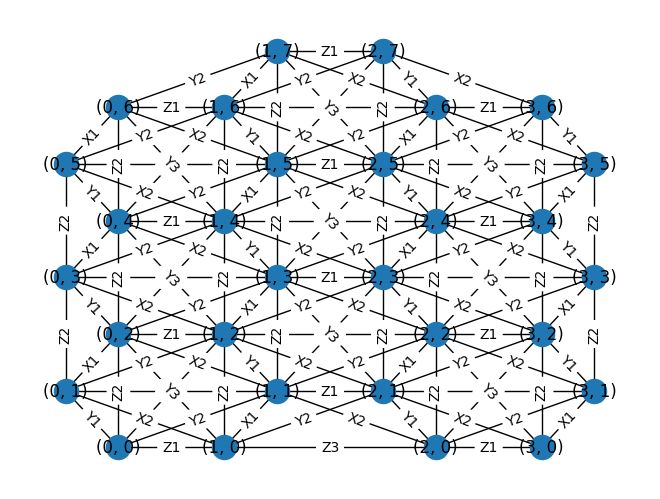

In [3]:
t_init = time.perf_counter()
def assign_hexagon_labels_rucl(graph):
    assign_hexagon_labels(graph, 'X1', 'Y1', 'Z1')
       
    #Adding next nearest and next-next nearest neighbor edges and labels
    for n in graph.nodes:
        r,c = n
        
        #next nearest neighbors
        if (r, c+2) in graph:
            graph.add_edge(n, (r, c+2), label = 'Z2')
        if (r+1, c+1) in graph:
            graph.add_edge(n, (r+1, c+1), label = 'Y2')
        if (r-1, c+1) in graph:
            graph.add_edge(n, (r-1, c+1), label = 'X2')
       
        #next-next nearest neighbors
        if (r+1, c) in graph and not ((n, (r+1, c)) in graph.edges):
            graph.add_edge(n, (r+1,c), label = 'Z3')
        if (r+1, c+2) in graph and (r + c)%2 == 0:
            graph.add_edge(n, (r+1, c+2), label= 'X3')
        if (r-1, c+2) in graph and (r + c)%2 == 1:
            graph.add_edge(n, (r-1, c+2), label= 'Y3')

g_rucl = hexagonal_lattice_graph(3,3)
pos = nx.get_node_attributes(g_rucl, 'pos')
assign_hexagon_labels_rucl(g_rucl)
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in g_rucl.edges(data=True)]);
nx.draw(g_rucl, pos, with_labels=True)
nx.draw_networkx_edge_labels(g_rucl, pos,edge_labels = edge_labels);

##### Figure 2

With the connectivity defined, we can construct a variety of Hamiltonians using the terms defined in [[1]](https://doi.org/10.1038/s41535-019-0203-y).  Some of the models contain more terms and thus take longer to run.  For the purposes of demonstration, row 13 tends to have the shortest runtime, so we use that for demonstration purposes here.  To run all rows, simply loop over all indices rather than just the 13th index.  The number after the terms in the following graph indicate how far away the interactions are.  For example J1 represents the nearest neighbor Heisenberg interactions, J2 represents the next-nearest neighbor Heisenberg interactions, and J3 represents the next-next-nearest neighbor Heisenberg interactions.  Any terms not present in the table that appear in the generic Hamiltonian defined above are treated as 0.

In [4]:
rucl_references = ["Winter et al. PRB", "Winter et al. NC", "Wu et al.", "Cookmeyer and Moore", "Kim and Kee", "Suzuki and Suga", 
              "Yadav et al.", "Ran et al.", "Hou et al.", "Wang et al.", "Eichstaedt et al.", "Eichstaedt et al.", 
              "Eichstaedt et al.", "Banerjee et al.", "Kim et al.", "Kim and Kee", "Winter et al.", "Ozel et al.", "Ozel et al."]

rucl_methods = ["Ab initio (DFT + exact diag.)", "Ab initio-inspired (INS fit)", "THz spectroscopy fit",
                "Magnon thermal Hall (sign)", "DFT + t=U expansion", "Magnetic specific heat", "Quantum chemistry (MRCI)",
                "Spin wave fit to INS gap", "Constrained DFT + U", "DFT + t=U expansion", "Fully ab initio (DFT + cRPA + t=U)",
                "Neglecting non-local Coulomb", "Neglecting non-local SOC", "Spin wave fit", "DFT + t=U expansion",
                "DFT + t=U expansion", "Ab initio (DFT + exact diag.)", "Spin wave fit/THz spectroscopy", "Spin wave fit/THz spectroscopy"]

rucl_J1 = [-1.7, -0.5, -0.35, -0.5, -1.53, -1.53, 1.2, 0, -1.87, -0.3, -1.4, -0.2, -1.3, -4.6, -12, -3.5, -5.5, -0.95, 0.46]
rucl_K1 = [-6.7, -5.0, -2.8, -5.0, -6.55, -24.4, -5.6, -6.8, -10.7, -10.9, -14.3, -4.5, -13.3, 7.0, 17., 4.6, 7.6, 1.15, -3.5]
rucl_Gam1 = [6.6, 2.5, 2.4, 2.5, 5.25, 5.25, 1.2, 9.5, 3.8, 6.1, 9.8, 3.0, 9.4, 0, 12., 6.42, 8.4, 3.8, 2.35]
rucl_Gam_prime1 = [-0.9, 0, 0, 0, -0.95, -0.95, -0.7, 0, 0, 0, -2.23, -0.73, -2.3, 0, 0, -0.04, 0.2, 0, 0]
rucl_J2 = [0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rucl_K2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.63, -0.33, -0.67, 0, 0, 0, 0, 0, 0]
rucl_J3 = [2.7, 0.5, 0.34, 0.1125, 0, 0, 0.25, 0, 1.27, 0.03, 1.0, 0.7, 1.0, 0, 0, 0, 2.3, 0, 0]
rucl_K3 = [0, 0, 0, 0, 0, 0, 0, 0, 0.63, 0, 0.03, 0.1, 0.1, 0, 0, 0, 0, 0, 0]

d_rucl = {'reference': rucl_references, 'method': rucl_methods, 'J1': rucl_J1, 'K1': rucl_K1,
          'Gam1': rucl_Gam1, 'Gam_prime1': rucl_Gam_prime1,
          'J2': rucl_J2, 'K2': rucl_K2, 'J3': rucl_J3, 'K3': rucl_K3}
df_rucl = pd.DataFrame(d_rucl)
df_rucl

,reference,method,J1,K1,Gam1,Gam_prime1,J2,K2,J3,K3
0,Winter et al. PRB,Ab initio (DFT + exact diag.),-1.70,-6.70,6.60,-0.90,0.00,0.00,2.7000,0.00
1,Winter et al. NC,Ab initio-inspired (INS fit),-0.50,-5.00,2.50,0.00,0.00,0.00,0.5000,0.00
2,Wu et al.,THz spectroscopy fit,-0.35,-2.80,2.40,0.00,0.00,0.00,0.3400,0.00
3,Cookmeyer and Moore,Magnon thermal Hall (sign),-0.50,-5.00,2.50,0.00,0.00,0.00,0.1125,0.00
4,Kim and Kee,DFT + t=U expansion,-1.53,-6.55,5.25,-0.95,0.00,0.00,0.0000,0.00
5,Suzuki and Suga,Magnetic specific heat,-1.53,-24.40,5.25,-0.95,0.00,0.00,0.0000,0.00
6,Yadav et al.,Quantum chemistry (MRCI),1.20,-5.60,1.20,-0.70,0.25,0.00,0.2500,0.00
7,Ran et al.,Spin wave fit to INS gap,0.00,-6.80,9.50,0.00,0.00,0.00,0.0000,0.00
8,Hou et al.,Constrained DFT + U,-1.87,-10.70,3.80,0.00,0.00,0.00,1.2700,0.63
9,Wang et al.,DFT + t=U expansion,-0.30,-10.90,6.10,0.00,0.00,0.00,0.0300,0.00


##### Table 1


Now we may construct the Hamiltonian in a form usable by pyLIQTR using the values defined in the table above.  We also allow for an additional time varying portion to represent the longitudinal field term.  In the future, we would like to extend the capability of this notebook to further explore implementing this term in a more precise manner with higher order Magnus expansions and selecting multiple time-slices for a more accurate approximation.

In [5]:
def nx_rucl_terms(graph, data_series):
    H = []
    n = len(graph.nodes)
    for (n1,n2,edge_data) in graph.edges(data=True):
        label = edge_data['label'][0]
        distance = int(edge_data['label'][1])
        
        #Heisenberg and Kitaev terms
        if distance == 1:
            weight_J = data_series.J1
            weight_K = data_series.K1
        elif distance == 2:
            weight_J = data_series.J2
            weight_K = data_series.K2
        elif distance == 3:
            weight_J = data_series.J3
            weight_K = data_series.K3
        else:
            raise ValueError(f'Invalid value for distance: {distance}. Expected 1, 2, or 3')
            
        
        if not (weight_J == 0 and weight_K == 0):
            string_x = n*'I' 
            string_y = n*'I' 
            string_z = n*'I'
            
            weight_x = weight_J
            weight_y = weight_J
            weight_z = weight_J
            for i in [n1,n2]:
                string_x = string_x[:i] + 'X' + string_x[i+1:]
                string_y = string_y[:i] + 'Y' + string_y[i+1:]
                string_z = string_z[:i] + 'Z' + string_z[i+1:]
            if label == 'X':
                weight_x += weight_K
            elif label == 'Y':
                weight_y += weight_K
            else:
                weight_z += weight_K
            if weight_x != 0:
                H.append((string_x, weight_x))
            if weight_y != 0:
                H.append((string_y, weight_y))
            if weight_z != 0:
                H.append((string_z, weight_z))
            
        #Gamma Terms
        if distance == 1 and data_series.Gam1 != 0:
            string_gam1_1 = n*'I'
            string_gam1_2 = n*'I'
            #unwrapping loop since there is no ordering guarantee
            labels=['X', 'Y', 'Z']
            labels.remove(label)
            l1,l2 = labels
            string_gam1_1 = string_gam1_1[:n1] + l1 + string_gam1_1[n1+1:]
            string_gam1_1 = string_gam1_1[:n2] + l2 + string_gam1_1[n2+1:]
            
            string_gam1_2 = string_gam1_2[:n1] + l2 + string_gam1_2[n1+1:]
            string_gam1_2 = string_gam1_2[:n2] + l1 + string_gam1_2[n2+1:]
            
            H.append((string_gam1_1, data_series.Gam1))
            H.append((string_gam1_2, data_series.Gam1))
            
        #Gamma' Terms
        if distance == 1 and data_series.Gam_prime1 != 0:
            #unwrapping inner loop since there is no ordering guarantee
            labels=['X', 'Y', 'Z']
            labels.remove(label)
            for label_offset in labels:
                string_gam1_1 = n*'I'
                string_gam1_2 = n*'I'
                l1 = label
                l2 = label_offset
                
                string_gam1_1 = string_gam1_1[:n1] + l1 + string_gam1_1[n1+1:]
                string_gam1_1 = string_gam1_1[:n2] + l2 + string_gam1_1[n2+1:]
                string_gam1_2 = string_gam1_2[:n1] + l2 + string_gam1_2[n1+1:]
                string_gam1_2 = string_gam1_2[:n2] + l1 + string_gam1_2[n2+1:]
                H.append((string_gam1_1, data_series.Gam_prime1))
                H.append((string_gam1_2, data_series.Gam_prime1))
    return H

def generate_time_varying_terms(graph, s, x = lambda s: 0, y = lambda s: 0, z = lambda s: 0):
    assert callable(x)
    assert callable(y)
    assert callable(z)
    
    weight_x, weight_y, weight_z = x(s), y(s), z(s)
    n = len(graph)
    H = []
    if not (weight_x == 0):
        for node in graph.nodes:
            string_x = n*'I'
            string_x = string_x[:node] + 'X' + string_x[node+1:]
            H.append((string_x, weight_x))
    if not (weight_y == 0):
        for node in graph.nodes:
            string_y = n*'I'
            string_y = string_y[:node] + 'Y' + string_y[node+1:]
            H.append((string_y, weight_y))
    if not (weight_z == 0):
        for node in graph.nodes:
            string_z = n*'I'
            string_z = string_z[:node] + 'Z' + string_z[node+1:]
            H.append((string_z, weight_z))
    return H

#using normalized time s = t_current / t_total to allow for more variation of total time
def generate_rucl_hamiltonian(lattice_size, data_series, s=0, field_x=lambda s: 0, field_y=lambda s: 0, field_z=lambda s: 0):
    graph = hexagonal_lattice_graph(lattice_size,lattice_size)
    assign_hexagon_labels_rucl(graph)
    graph = flatten_nx_graph(graph)
    H_constant = nx_rucl_terms(graph, data_series)
    H_time_varied = generate_time_varying_terms(graph, s, x=field_x, y = field_y, z = field_z)
    H = H_constant + H_time_varied
    return H

Next, we need to implement a circuit to prepare an initial estimate for the ground state of RuCl with a high degree of overlap with the actual ground state.  It has been observed experimentally that at low temperatures $\alpha-RuCl_3$ corresponding to a zig-zag spin structure, seen in Figure 3.  In the presence of an external magnetic field, this state is non-degenerate and can be prepared by implementing local rotations on individual sites.  

The change of basis matrix from the $\hat{x}$, $\hat{y}$, $\hat{z}$ axis to the $\hat{a}$, $\hat{b}$, $\hat{c}$ axis is as follows:

\begin{equation}
\begin{bmatrix} \hat{a} \\ \hat{b} \\ \hat{c} \end{bmatrix} = \begin{bmatrix} \frac{1}{\sqrt{6}} & \frac{1}{\sqrt{6}} & -\frac{2}{\sqrt{6}}\\
                 \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\
                 \frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}}
\end{bmatrix}
\begin{bmatrix} \hat{x} \\ \hat{y} \\ \hat{z} \end{bmatrix}
\end{equation}

This state may be prepared by initializing the spins in the $\hat{z}$ eigenbasis $|0...0\rangle$ then applying $\sigma^x$ operations on the appropriate sites to form the zig-zag pattern.  Next, the sites are rotated about the $\hat{c}$ axis until the state has maximum overlap with the $\hat{a}$ direction.  The angle of rotation required in this instance is a rotation of $\theta = \pi$ about the $\hat{c}$ axis.  This rotation can be achieved by performing a sequence of rotations evaluated from right to left): $R^z_i(- \pi/4) \cdot R^x_i(- \pi/4) \cdot \sigma^z_i \cdot R^x_i(\pi/4) \cdot R^z_i(\pi/4)$.  We show below how one may construct this initial state below.  This ground state is biased in the presence of a uniform magnetic field, representing the Zeeman terms in the $\hat{a}$ direction, making the Zeeman terms 
\begin{equation}
H_{field}(t) = t \sum_i \left(\frac{1}{\sqrt{6}}\sigma^x_i + \frac{1}{\sqrt{6}}\sigma^y_i - \frac{2}{\sqrt{6}}\sigma^z_i \right)
\end{equation}

Once all of this has been done, the state has been prepared and the dynamics may be executed.

<img src="EmbeddedFigures/RuCl3_spinstructure.jpeg" alt="RuCl_Spin_Structure" width="800"/>

##### Figure 3

0: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

1: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

2: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

3: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

4: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

5: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

6: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

7: ────X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.25π)───

8: ────X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.25π)───

9: ────X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.25π)───

10: ───X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.25π)───

11: ───X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.2

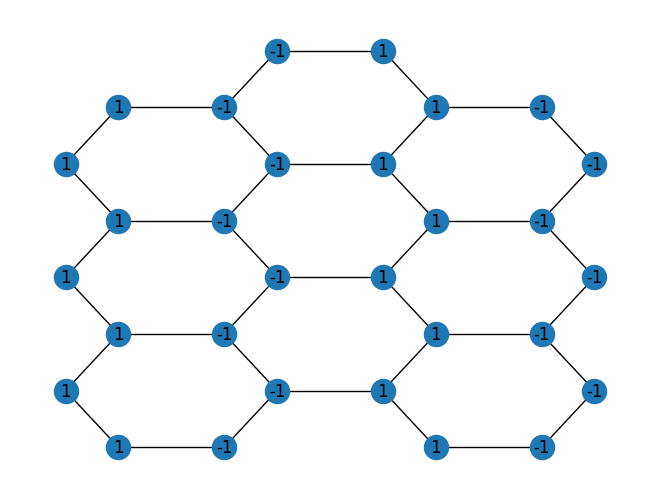

In [16]:
def assign_spin_labels_rucl(lattice_size):
    #We may omit NN and NNN couplings for the purposes of clarity in state prep
    graph = hexagonal_lattice_graph(lattice_size, lattice_size)
    spin_labels = dict([(node, pow(-1, node[0])) for node in graph])
    nx.set_node_attributes(graph, spin_labels, name= 'spin')
    return graph

def prepare_initial_state_rucl(graph):
    #site labels are assumed to be the same as for hamiltonian with NN and NNN couplings
    #because they come from the same base generator
    graph = flatten_nx_graph(graph)
    spins = nx.get_node_attributes(graph, 'spin')
    qubits = [cirq.LineQubit(i) for i in graph.nodes]
    
    #generating layers of operations to initialize state
    layer_zig_zag = [cirq.X(qubits[i]) for i in range(len(graph)) if spins[i] == -1]
    layer_rz = [cirq.Rz(rads = np.pi/4).on(qubit) for qubit in qubits]
    layer_rx = [cirq.Rx(rads = np.pi/4).on(qubit) for qubit in qubits]
    layer_z = [cirq.Z(qubit) for qubit in qubits]
    layer_rx_neg = [cirq.Rx(rads=-np.pi/4).on(qubit) for qubit in qubits]
    layer_rz_neg = [cirq.Rz(rads=-np.pi/4).on(qubit) for qubit in qubits]

    #appending layers to a circuit to return
    circuit = cirq.Circuit()
    circuit.append(layer_zig_zag)
    circuit.append(layer_rz)
    circuit.append(layer_rx)
    circuit.append(layer_z)
    circuit.append(layer_rx_neg)
    circuit.append(layer_rz_neg)
    return circuit
    
graph_spins = assign_spin_labels_rucl(3)
circuit_state_prep = prepare_initial_state_rucl(graph_spins)
pos = nx.get_node_attributes(graph_spins, 'pos')
spin_labels = nx.get_node_attributes(graph_spins, 'spin')
nx.draw(graph_spins, labels = spin_labels, pos=pos, with_labels=True)
print(circuit_state_prep)

Finally, it is time to implement the circuit for simulating the time dynamics of $H$, parameterized by the rows of Table 1.  First we perform the simulation using the second order Trotter expansion.  We choose an energy precision of $10^{-3}$, which is believed to be sufficiently low to allow for lower circuit depths while still getting empirically accurate results.  We construct a lattice of size 32x32 honeycomb cells to hopefully have a sufficiently large mass to mitigate finite size effects.  This is believed to be the lower end of what lattice size would be useful, and larger may be better in some cases.  Finally, we plot the a histogram of the T-widths that occur on each layer of the circuit.  The x-axis representing the number of parallel T-gates and the y-axis representing the number of layers where that T-width is found.  This is done to determine the value of the parallelizability of T factories on a theoretical Fault Tolerant Device using a Clifford + T gateset.  

Estimating RuCl row 13 using Trotterization
Time to estimate number of trotter steps required (215647636): 39.37467879099859 seconds
Time to find term ordering: 0.026006125001003966 seconds
Time to generate trotter circuit from openfermion: 1.1250012903474271e-06 seconds
Time to generate a clifford + T circuit from trotter circuit: 180.79575008300162 seconds
Total time to estimate RuCl row 13: 308.43684933299664 seconds



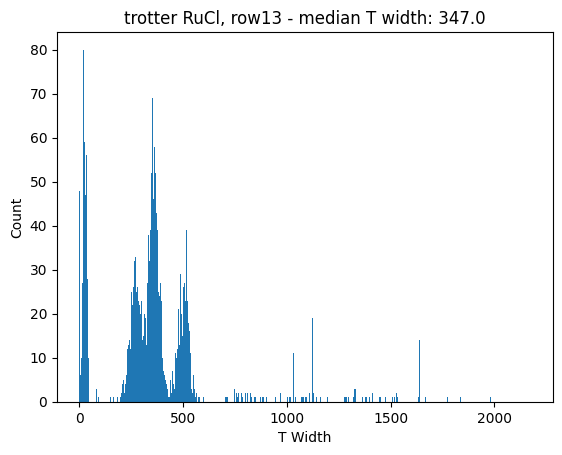

In [7]:
#Commenting out range, to avoid long runtimes.  This still takes ~20-30 minutes as written
for i in [13]:
#for i in range(19):
    #defining precision required for the trotterized circuit
    lattice_size = 32
    evolution_time=1000
    trotter_order = 2
    energy_precision = 1e-3
    extrapolated=True


    figdir="Trotter/Figures/"
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    widthdir = "Trotter/Widths/"
    if not os.path.exists(widthdir):
        os.makedirs(widthdir)



    H_rucl = generate_rucl_hamiltonian(lattice_size, df_rucl.iloc[i], field_x=lambda s: 1/sqrt(6), field_y=lambda s: 1/sqrt(6), field_z=lambda s: -2/sqrt(6))
    H_rucl_pyliqtr = pyH(H_rucl)
    openfermion_hamiltonian_rucl = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_rucl_pyliqtr)
    
    rucl_name = f'Rucl_row_{i}_trotter'
    hash_uid = hashlib.sha256(rucl_name.encode('utf-8'))
    uid = hash_uid.hexdigest()


    trotter_metadata = TrotterMetaData(
        id = uid,
        name=rucl_name,
        category='scientific',
        size=f'lattice_size: {lattice_size}',
        task='Time-Dependent Dynamics',
        evolution_time=evolution_time,
        trotter_order=trotter_order,
        energy_precision=energy_precision,
        is_extrapolated=extrapolated,
    )

    print(f'Estimating RuCl row {i} using Trotterization')
    t0 = time.perf_counter()
    cpt_trotter_rucl = estimate_trotter(
        openfermion_hamiltonian=openfermion_hamiltonian_rucl,
        evolution_time=evolution_time,
        energy_precision=energy_precision,
        trotter_order=trotter_order,
        outdir='Trotter/RuCl_circuits/',
        metadata=trotter_metadata,
        is_extrapolated=extrapolated,
        hamiltonian_name=f'rucl_trotter_{i}_test',
        write_circuits=True
    )
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("Total time to estimate RuCl row " + str(i) + ": " + str(elapsed) + " seconds\n")
    
    plot_histogram(
        cpt_trotter_rucl,
        f'trotter RuCl, row{i}',
        figdir,
        widthdir,
        0
    )

Finally we perform the same experiment for the Quantum Signal Processing algorithm.  We omit plotting in this case because we perform estimation of the circuit by decomposing sub-circuits of the overall algorithm.  This results in some sub-circuits where parallelizability may appear deceptively high, or no T gates may even be present.  Emperically, for the portions of the circuit which compose the bulk of the circuit (SELECT and REFLECT operators), the T width tends to be near 1.

In [ ]:
#Commenting out range, to avoid long runtimes.  This still takes ~20-30 minutes as written

#defining precision required for the trotterized circuit

lattice_size=32
evolution_time=1000
nsteps=1000
energy_precision = 1e-3

for i in [13]:
#for i in range(19):
    figdir="QSP/Figures/"
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    widthdir = "QSP/Widths/"
    if not os.path.exists(widthdir):
        os.makedirs(widthdir)

    H_rucl = generate_rucl_hamiltonian(lattice_size, df_rucl.iloc[i], field_x=lambda s: 1/sqrt(6), field_y=lambda s: 1/sqrt(6), field_z=lambda s: -2/sqrt(6))
    H_rucl_pyliqtr = pyH(H_rucl)
    
    rucl_name = f'Rucl_row_{i}_qsp'
    hash_uid = hashlib.sha256(rucl_name.encode('utf-8'))
    uid = hash_uid.hexdigest()

    qsp_metadata = QSPMetaData(
        id=uid,
        name=rucl_name,
        category='scientific',
        size=f'lattice_size: {lattice_size}',
        task='Time-Dependent Dynamics',
        evolution_time=evolution_time,
        nsteps=nsteps,
        energy_precision=energy_precision,
    )
    
    print(f'Estimating RuCl row {i} using QSP')
    t0 = time.perf_counter()
    # change to Clifford+T dictionary in future revision
    qsp_high_level_rucl = estimate_qsp(
        pyliqtr_hamiltonian=H_rucl_pyliqtr,
        evolution_time=evolution_time,
        nsteps=nsteps,
        energy_precision=energy_precision,
        outdir='QSP/RuCl_circuits/',
        hamiltonian_name=f'rucl_qsp_{i}_test',
        metadata=qsp_metadata,
        write_circuits=True
    )
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print(f'Time to estimate RuCl row {i}: {elapsed} seconds\n')
    print()

Estimating RuCl row 13 using QSP
Time to generate high level QSP circuit: 106.46940012497362 seconds
   Time to decompose high level _PauliX circuit: 7.374997949227691e-05 seconds 
   Time to transform decomposed _PauliX circuit to Clifford+T: 2.3500004317611456e-05 seconds
   Time to decompose high level Rx circuit: 2.4666020181030035e-05 seconds 
   Time to transform decomposed Rx circuit to Clifford+T: 0.008130667032673955 seconds
   Time to decompose high level UnitaryBlockEncode circuit: 25.91511416702997 seconds 
   Time to transform decomposed UnitaryBlockEncode circuit to Clifford+T: 150.9490537919919 seconds
   Time to decompose high level Ry circuit: 0.10220795898931101 seconds 
   Time to transform decomposed Ry circuit to Clifford+T: 0.005874917027540505 seconds
   Time to decompose high level _InverseCompositeGate circuit: 28.04190108302282 seconds 
   Time to transform decomposed _InverseCompositeGate circuit to Clifford+T: 135.57108429196524 seconds
   Time to decompose 

The final observable being measured is net magnetization, which can be obtained by simply measuring all of the qubits in the desired basis (in this case, the $\hat{a}$, $\hat{b}$, $\hat{c}$ basis), and summing the spins on all of the sites.  Since the computational basis is in the $\hat{z}$ direction, we will need to implement a change of basis operation.  For the purposes of this demonstration, we will use the measure in the $\hat{c}$ direction, for which the transformation $R^x_i(\pi/4) \cdot R^z_i(\pi/4)$ applied on each qubit before measurement is sufficient.  This resource requirement, like the requirement for running the state preparation is constant, both in the sense that it needs to be performed for every circuit and in the sense that depth added to the circuit is $\mathcal{O}(1)$. For this reason, we perform the resource estimates for the state preparation and observable measurement separately from the dynamic circuits which are implemented based on Hamiltonian parameterizations. Below, we provide the resource estimates for both the state preparation and measurement (the state preparation circuit generator is defined above)

In [ ]:
def prepare_measurement_rucl(graph):
    #site labels are assumed to be the same as for hamiltonian with NN and NNN couplings
    #because they come from the same base generator
    graph = flatten_nx_graph(graph)
    qubits = [cirq.LineQubit(i) for i in graph.nodes]
    
    #generating layers of operations to initialize state
    layer_rz = [cirq.Rz(rads = np.pi/4).on(qubit) for qubit in qubits]
    layer_rx = [cirq.Rx(rads = np.pi/4).on(qubit) for qubit in qubits]
    layer_measurement = [cirq.measure(qubit) for qubit in qubits]
    #appending layers to a circuit to return
    circuit = cirq.Circuit()
    circuit.append(layer_rz)
    circuit.append(layer_rx)
    circuit.append(layer_measurement)
    return circuit

#example instance for clear printing and verification of the correct operators
circuit_measurement = prepare_measurement_rucl(graph_spins)
print(circuit_measurement)

0: ────Rz(0.25π)───Rx(0.25π)───M───

1: ────Rz(0.25π)───Rx(0.25π)───M───

2: ────Rz(0.25π)───Rx(0.25π)───M───

3: ────Rz(0.25π)───Rx(0.25π)───M───

4: ────Rz(0.25π)───Rx(0.25π)───M───

5: ────Rz(0.25π)───Rx(0.25π)───M───

6: ────Rz(0.25π)───Rx(0.25π)───M───

7: ────Rz(0.25π)───Rx(0.25π)───M───

8: ────Rz(0.25π)───Rx(0.25π)───M───

9: ────Rz(0.25π)───Rx(0.25π)───M───

10: ───Rz(0.25π)───Rx(0.25π)───M───

11: ───Rz(0.25π)───Rx(0.25π)───M───

12: ───Rz(0.25π)───Rx(0.25π)───M───

13: ───Rz(0.25π)───Rx(0.25π)───M───

14: ───Rz(0.25π)───Rx(0.25π)───M───

15: ───Rz(0.25π)───Rx(0.25π)───M───

16: ───Rz(0.25π)───Rx(0.25π)───M───

17: ───Rz(0.25π)───Rx(0.25π)───M───

18: ───Rz(0.25π)───Rx(0.25π)───M───

19: ───Rz(0.25π)───Rx(0.25π)───M───

20: ───Rz(0.25π)───Rx(0.25π)───M───

21: ───Rz(0.25π)───Rx(0.25π)───M───

22: ───Rz(0.25π)───Rx(0.25π)───M───

23: ───Rz(0.25π)───Rx(0.25π)───M───

24: ───Rz(0.25π)───Rx(0.25π)───M───

25: ───Rz(0.25π)───Rx(0.25π)───M───

26: ───Rz(0.25π)───Rx(0.25π)───M───

2

In [ ]:
graph_spins = assign_spin_labels_rucl(32)
circuit_state_prep_and_measurement = prepare_initial_state_rucl(graph_spins) + prepare_measurement_rucl(graph_spins)
circuit_state_prep_and_measurement_cpt = clifford_plus_t_direct_transform(circuit_state_prep_and_measurement)

In [ ]:
state_prep_estimate = gen_resource_estimate(circuit_state_prep_and_measurement_cpt, is_extrapolated=False)
re_as_json(state_prep_estimate, outdir='state_preparation_and_measurement.json')

In [ ]:
t_end = time.perf_counter()
print("Total time to run notebook (only using the fastest row): " + str(t_end - t_init))

Total time to run notebook (only using the fastest row): 1011.2058625000063


### Application 2 - Ground State Energy Estimation using Trotterized Subprocess

The spin structure of the ground state at zero external magnetic field can be inferred from magnetization-temparature and magnetic field measurements. Initially, we categorize whether a system exhibits magnetic long-range ordering, discernible through sigularities such as divergences or kinks in the magnetization measurement, indicative of a symmetry-breaking phase transition. 

Subsequentially, we ascertain if the magnetic ordering possesses a net magnetization. In the presence of a net magnetic component, particularly a ferromagnetic one, distinctions often arise between zero field cooled and field cooled states owing to magnetic domain effects. The direction of the ferromagnetic component can be deduced from the magnitude of magnetization.

In the case of antiferromagnetism, understanding how spins counterbalance is achieved by analyzing magnetization against temperature and magnetic field in various orientations. When the magnetic field aligns with spin directions, the net magnetization approaches zero in the limit of zero temperature; however, when perpendicular to the spins, a temperature-independent finite magnetization is observed. The magnetization-field curve illustrates spin flip or flop transitions, marked by sudden changes when the field aligns with spin directions and gradual increases when perpendicular. Symmetry-sensitive techniques, such as electric polarization, are also employed. Depending on the spin structure's symmetry, linear magnetoelectric coupling or second-order magnetoelectric coupling may be allowed. 

Finally, we validate the symmetry through neutron diffraction experiments. In the presence of magnetic ordering, magneitc Bragg peaks emerge in momentum space, aligning with the wave vector of the spin ordering. Analyzing these magnetic Bragg peaks allows us to infer the spin arrangement and magnetic interactions within the material. The intensity of the peaks serves as an indicator of the magnetic order's strength, while the positions of the peaks unveil the sptial distribution of the magnetic moments.

The objective is to identify which of the candidate Hamiltonians in Figure 2-7 is able to predict the experimentally observed ground state in Figure 2-8 at zero external magnetic field. 

<br>

There are 3 steps to estimate the ground state energy of this Hamiltonian using Trotterized Subprocess: 

   1. Prepare ground state $\rho_i$ where the initial state is set using DMRG. This is assumed to be completed, since it cannot be incorporated into the notebook.
    
   2. Generating the RuCl Hamiltonian with zero external magnetic field. The Hamiltonian is then converted to a Openfermion Qubit Operator.
    
   3. Compute Ground State Energy Estimation using Trotterized Subprocess, which is parametrized by the rows of Table 1.

<br>
<br>

Note: There is another workflow in generating resource estimates using PyLIQTR's Qubitized Phase Estimation Algorithm for Ground State Energy Estimation. However, due to the package not being able to support the Hamiltonian Construction needed at this moment, only a model of steps are given if it was incorporated: 
   
   1. Generate the terms for the RuCl Hamiltonian, which is done in the Trotterized Subprocess below. This terms dictionary will need to be restructured to be used in the model instantiation for QPE in PyLIQTR. 
   
   2. Create the Hamiltonian using PyLIQTR's ProblemInstance() and getInstance() interface to be used in the QPE algorithm. In this case, the Heisenberg instance would be used to create the Hamiltonian, where the field (h) is set to (0.0,0.0,0.0), the cell type is of a Hexagonal lattice structure, and a restructured terms dictionary is given as input into the instance. 

   3. Select a block encoding the Hamiltonian, using conventional Select-Prepare sequence based on a linear combination of unitaries (LCU). Here, one can create the Block Encoding, and see the resource estimations of the Block Encoding and of the Walk Operator. The leading overhead comes from the Walk operator, which can be assembled and assessed in isolation.
   
   4. Compute Ground State Energy Estimation using Qubitized Phase Estimation. If the user wants a lower bound on their resource estimates, which tends to run quicker, use PyLIQTR's estimate_resources() function. If the user wants explicit resource estimates, use QCA's circuit_estimate() function.

   


First, we use classical methods such as DMRG for initialization. Since this cannot be incorporated into the notebook, we assume it has been prepared. Instead, we set the size of the initial state equal to the number of nodes in the Hexgonal Lattice Graph.

In [6]:
#Assume the initial state for GSEE has been prepared through DMRG.

#Here we use a placement-holder for the initial state equal to the number of nodes in the hexagonal lattice graph:
lattice = 10
graph = hexagonal_lattice_graph(lattice,lattice)
assign_hexagon_labels(graph)
graph = flatten_nx_graph(graph)

n_qubits = len(graph.nodes)
init_state = [0] * n_qubits

Generating the Hamiltonian: Generating the RuCl Hamiltonian with zero external magnetic field
\begin{equation}
  H = H_{material} + H_{field}(0)
\end{equation}


Here we see that $s=0$, which means for the time varying portion, it will just return an empty list when constructing the Hamiltonian, and so the $H_{field}(s)$ does not contribute to the Hamiltonian, and the complete Hamiltonian $H$ simplifies to just $H_{material}$

In [9]:
#Generating Hamiltonian with zero external magnetic field. (H_field = 0)
#This is the way that it is prepared using QCA which we will see later in the Trotterized subprocess

H_rucl_no_field = generate_rucl_hamiltonian(32, df_rucl.iloc[0], field_x=lambda s: 0, field_y=lambda s: 0, field_z=lambda s: 0) ###Note df_rucl.iloc[i] used information from the table
H_rucl_no_field_pyliqtr = pyH(H_rucl_no_field)
H_rucl_no_field_qubit_op = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_rucl_no_field_pyliqtr)

Implementation of Ground State Energy Estimation using Trotterized Subprocess, parametrized by row 13 of Table 1. For the purposes of demonstration, row 13 tends to have the shortest runtime, and is used here. Bits precision is set to 10. We construct a lattice of size 32x32 honeycomb cells to hopefully have a sufficiently large mass to mitigate finite size effects. 

In [7]:
###Trotterized Subprocess
for i in [13]:
    bits_precision = 10 
    trotter_order = 2
    trotter_steps = 1
    lattice_size = 32

    H_rucl_no_field = generate_rucl_hamiltonian(lattice_size, df_rucl.iloc[i], field_x=lambda s: 0, field_y=lambda s: 0, field_z=lambda s: 0)
    H_rucl_no_field_pyliqtr = pyH(H_rucl_no_field)
    H_rucl_no_field_qubit_op = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_rucl_no_field_pyliqtr)

    rucl_name = f'Rucl_row_{i}_GSEE'
    E_min = -len(H_rucl_no_field_qubit_op.terms)
    E_max = 0
    omega = E_max-E_min
    t = 2*np.pi/omega
    phase_offset = E_max*t

    rucl_metadata = GSEEMetaData(
        id = 2000,
        name = rucl_name,
        category='scientific',
        size=f'{lattice_size}',
        task='Ground State Energy Estimation',
        evolution_time=t,
        is_extrapolated=True,
        trotter_order=trotter_order,
        bits_precision=bits_precision,
        nsteps=trotter_steps,

    )

    gsee_args = {
        'trotterize' : True,
        'mol_ham'    : H_rucl_no_field_qubit_op,
        'ev_time'    : t,
        'trot_ord'   : trotter_order,
        'trot_num'   : trotter_steps
    }

    #Initial State
    graph = hexagonal_lattice_graph(lattice_size,lattice_size)
    assign_hexagon_labels(graph)
    graph = flatten_nx_graph(graph)
    n_qubits = len(graph.nodes)
    init_state = [0] * n_qubits #Assume DMRG is used in initial state prep

    print(f'Estimating RuCl Ham row {i} of size {lattice_size}')
    t0 = time.perf_counter()
    gsee_resource_estimation(
        outdir='GSEE/RuCl_GSEE/No_Field/',
        nsteps=trotter_steps,
        gsee_args=gsee_args,
        init_state=init_state,
        precision_order=1,
        bits_precision=bits_precision,
        phase_offset=phase_offset,
        circuit_name=f'H_rucl_no_field',
        metadata=rucl_metadata,
        write_circuits=False
    )
    t1 = time.perf_counter()
    print(f'Time to estimate RuCl Ham with no external field: {t1-t0}')

Estimating RuCl Ham row 13 of size 32
Time to generate circuit for GSEE: 0.04972362499393057 seconds
   Time to decompose high level HPowGate circuit: 0.0001714999962132424 seconds 
   Time to transform decomposed HPowGate circuit to Clifford+T: 0.0005693749990314245 seconds
   Time to decompose high level IdentityGate circuit: 1.3791999663226306e-05 seconds 
   Time to transform decomposed IdentityGate circuit to Clifford+T: 3.8330035749822855e-06 seconds
   Time to decompose high level PhaseOffset circuit: 7.704199379077181e-05 seconds 
   Time to transform decomposed PhaseOffset circuit to Clifford+T: 8.791700383881107e-05 seconds
   Time to decompose high level Trotter_Unitary circuit: 41.15218574999744 seconds 
   Time to transform decomposed Trotter_Unitary circuit to Clifford+T: 205.24818237499858 seconds
   Time to decompose high level MeasurementGate circuit: 0.0322001660024398 seconds 
   Time to transform decomposed MeasurementGate circuit to Clifford+T: 7.400000322377309e-0

### References
[1] Laurell, P., Okamoto, S. Dynamical and thermal magnetic properties of the Kitaev spin liquid candidate α-RuCl3. npj Quantum Mater. 5, 2 (2020). https://doi.org/10.1038/s41535-019-0203-y

[2] Javier Gonzalez-Conde, Zachary Morrell, Marc Vuffray, Tameem Albash, Carleton Coffrin The Cost of Emulating a Small Quantum Annealing Problem in the Circuit-Model https://arxiv.org/abs/2402.17667

[3] Zachary Morrell, Marc Vuffray, Sidhant Misra, Carleton Coffrin QuantumAnnealing: A Julia Package for Simulating Dynamics of Transverse Field Ising Models https://arxiv.org/abs/2404.14501